In [1]:
import sys
sys.path.append("../")
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from config import DataConfig as data_cfg

from train2d import VAETrainer
from data_generation.dataset import VonKarmanXY
torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAETrainer.load_from_checkpoint("../checkpoints/epoch=0-step=125000-v2.ckpt").to(device)
encode_fn = model.vae.encoder

upsample = nn.Upsample(**data_cfg.upsample_kwargs)  # type: ignore
L0_vals = np.logspace(**data_cfg.L0_vals_logspace_kwargs)  # type: ignore
dataset = VonKarmanXY(
    **data_cfg.test_dataset_kwargs,  # type: ignore
    L0_vals=L0_vals,
    tfms=upsample,
)

N1 = 100
dl = torch.utils.data.DataLoader(dataset, batch_size=N1, num_workers=4)

In [2]:
batch = next(iter(dl))

In [5]:
N2 = 100
n, L0 = batch
_, dist = model.vae(n.to(device), L0[:,None].to(device))

z = dist.rsample((N2,))
z.shape

torch.Size([100, 100, 512])

In [6]:
# combine all the samples
z = z.view(-1, z.shape[-1])
z.shape

torch.Size([10000, 512])

In [7]:
# mean stats
mu_est = z.mean(axis=0, keepdim=True)
mu_est.mean(), mu_est.std() / np.sqrt(N1*N2)

(tensor(-0.0008), tensor(0.0003))

In [8]:
mu_est.shape

torch.Size([1, 512])

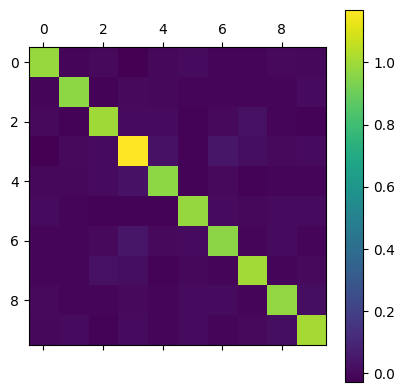

In [9]:
# covariance stats
cov_est = torch.cov(z.T)
cov_plt = cov_est[:10, :10].numpy()

plt.matshow(cov_plt)
plt.colorbar()


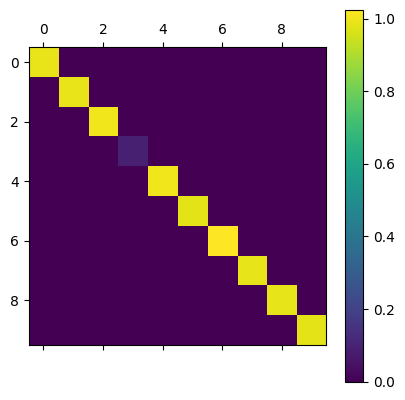

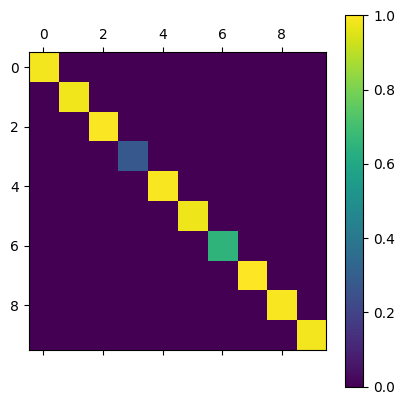

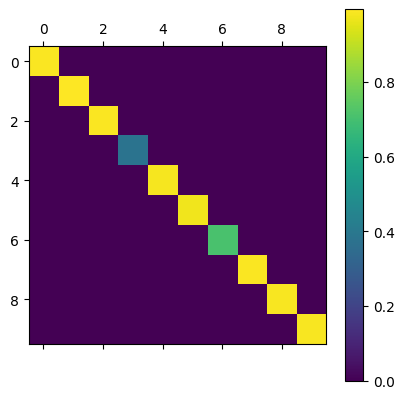

In [10]:
for i in range(3):
    plt.matshow(dist.covariance_matrix[i, :10, :10].cpu().numpy())
    plt.colorbar()
    plt.show()

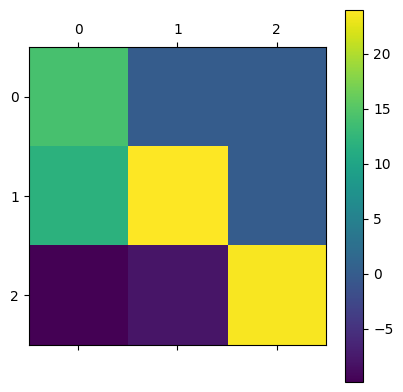

In [11]:
plt.matshow(dist._capacitance_tril[10])
plt.colorbar()